# E-commerce 쇼핑 
RFM은 구매의 최근성(Recency), 구매 빈도(Frequency), 총 구매 금액 (Monetary)의 약자  
RFM을 기준으로 고객 분류 알고리즘  

2876 rows  
## 1. 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 500)

In [2]:
df_org = pd.read_csv('order_data_202110.csv')
# df

In [3]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877 entries, 0 to 2876
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주문번호         2877 non-null   object 
 1   품목별 주문번호     2877 non-null   object 
 2   총 주문금액       2877 non-null   float64
 3   총 결제금액       2877 non-null   float64
 4   상품번호         2877 non-null   int64  
 5   주문상품명        2877 non-null   object 
 6   주문상품명(옵션포함)  2877 non-null   object 
 7   수량           2877 non-null   int64  
 8   판매가          2877 non-null   float64
 9   수령인          2877 non-null   int64  
 10  수령인 우편번호     2877 non-null   object 
 11  수령인 주소       2874 non-null   object 
 12  결제구분         2877 non-null   object 
 13  결제수단         2877 non-null   object 
 14  발주일          2830 non-null   object 
 15  배송국가         4 non-null      object 
dtypes: float64(3), int64(3), object(10)
memory usage: 359.8+ KB


## 2. EDA
### 2-1. 원본데이터

In [4]:
df = df_org.copy()
df2 = pd.DataFrame(df['주문상품명(옵션포함)'].str.split('수량=').tolist(), columns=['상품명', '옵션수량'])

# 수량 정리
df2['옵션수량'] = df2['옵션수량'].str[:1]
df['옵션수량'] = df2['옵션수량']
df['옵션수량'] = pd.to_numeric(df['옵션수량'])
df['옵션수량'] = df['옵션수량'].fillna(1)
df['결제구분'] = df['결제구분'].map({'T': 1, 'F': 0})
df['수량'] = df['수량'] * df['결제구분']
df['총수량'] = df['수량'] * df['옵션수량']

# 지난 거래일까지의 일수 구하기
df['지난발주일'] = df.groupby(['수령인'])['발주일'].shift(1)
df['발주일'] = pd.to_datetime(df['발주일'])
df['지난발주일'] = pd.to_datetime(df['지난발주일'])
df['거래경과일수'] = df['발주일'] - df['지난발주일']
df['거래경과일수'] = df['거래경과일수'].dt.days
df['거래경과일수'] = df['거래경과일수'].replace(-1, 0)

# 실결제금액
df['실결제금액'] = df['총 주문금액'] * df['결제구분']

# 0값
df = df.fillna(0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877 entries, 0 to 2876
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   주문번호         2877 non-null   object 
 1   품목별 주문번호     2877 non-null   object 
 2   총 주문금액       2877 non-null   float64
 3   총 결제금액       2877 non-null   float64
 4   상품번호         2877 non-null   int64  
 5   주문상품명        2877 non-null   object 
 6   주문상품명(옵션포함)  2877 non-null   object 
 7   수량           2877 non-null   int64  
 8   판매가          2877 non-null   float64
 9   수령인          2877 non-null   int64  
 10  수령인 우편번호     2877 non-null   object 
 11  수령인 주소       2877 non-null   object 
 12  결제구분         2877 non-null   int64  
 13  결제수단         2877 non-null   object 
 14  발주일          2877 non-null   object 
 15  배송국가         2877 non-null   object 
 16  옵션수량         2877 non-null   float64
 17  총수량          2877 non-null   float64
 18  지난발주일        2877 non-null   object 
 19  거래경과일수

### 2-2. 상품 데이터 (goods)

In [6]:
# 상품별 결제금액, 총결제금액, 총수량
df_goods_sum = df.groupby('상품번호').sum()
df_goods_sum.reset_index(inplace=True)
df_goods_sum = df_goods_sum.astype(int)

# 상품별 판매가
df_goods_mean = df.groupby('상품번호').mean()
df_goods_mean.reset_index(inplace=True)
df_goods_mean = df_goods_mean.astype(int)

# 상품정보
goods = pd.DataFrame()
goods['상품번호'] = df_goods_mean['상품번호']
# goods['mean_상품번호'] = df_mean['상품번호']
goods['판매가'] = df_goods_mean['판매가']
goods['총판매수량'] = df_goods_sum['총수량']
goods['누적판매금액'] = goods['판매가'] * goods['총판매수량']
goods

,상품번호,판매가,총판매수량,누적판매금액
0,64,5500,2,11000
1,96,69900,4048,282955200
2,101,17900,94,1682600
3,103,19800,198,3920400
4,105,35200,18,633600
5,106,49900,26,1297400
6,115,19900,112,2228800
7,116,29500,3,88500
8,118,22200,210,4662000
9,119,99900,9,899100


<AxesSubplot:xlabel='상품번호', ylabel='누적판매금액'>

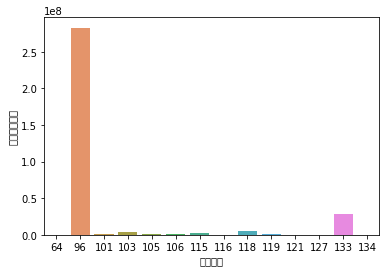

In [7]:
# best goods
sns.barplot(x='상품번호', y='누적판매금액', data=goods)

<AxesSubplot:xlabel='상품번호', ylabel='총판매수량'>

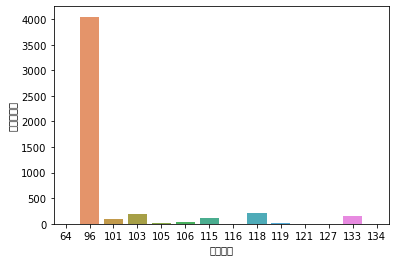

In [8]:
sns.barplot(x='상품번호', y='총판매수량', data=goods)

### 2-3. 고객 데이터 (customer)

In [9]:
# 고객별 결제금액, 총결제금액, 총수량, 구매횟수
df_cus_sum = df.groupby('수령인').sum()
df_cus_sum.reset_index(inplace=True)
df_cus_sum = df_cus_sum.astype(int)

# 주문횟수 확인 - 발주일 count
df_cus_count = df.groupby('수령인').count()

# 재주문까지 걸리는 평균기간
df_cus_mean = df.groupby('수령인').mean()

# 고객정보
customer = pd.DataFrame()
customer['수령인'] = df_cus_sum['수령인']
customer['총구매제품갯수'] = df_cus_sum['총수량']
customer['누적결제금액'] = df_cus_sum['실결제금액']
customer['구매시도'] = df_cus_count['발주일']
customer['구매횟수'] = df_cus_sum['결제구분']
customer['1회당평균구매금액'] = customer['누적결제금액'] / customer['구매횟수']
customer['1회당평균구매금액'] = customer['1회당평균구매금액'].replace(np.inf, 0)
customer['1회당평균구매금액'] = customer['1회당평균구매금액'].replace(np.nan, 0)
customer['재주문기간(일)'] = df_cus_mean['거래경과일수']
customer = customer.astype(int)
customer

,수령인,총구매제품갯수,누적결제금액,구매시도,구매횟수,1회당평균구매금액,재주문기간(일)
0,0,1,19800,3,1,19800,0
1,1,1,69900,1,1,69900,0
2,2,2,125800,1,1,125800,0
3,3,1,69900,1,1,69900,0
4,4,1,69900,1,1,69900,0
...,...,...,...,...,...,...,...
2055,2055,2,191200,2,2,95600,0
2056,2056,2,126000,1,1,126000,0
2057,2057,2,126000,1,1,126000,0
2058,2058,1,44500,1,1,44500,0


In [10]:
# 구매 선호 가격 확인 - 1회당평균구매금액의 평균값 101,631원
customer.describe()

,수령인,총구매제품갯수,누적결제금액,구매시도,구매횟수,1회당평균구매금액,재주문기간(일)
count,2060.000000,2060.000000,2.060000e+03,2060.000000,2060.000000,2060.000000,2060.000000
mean,1029.500000,2.373786,1.463604e+05,1.396602,1.373786,101042.645631,5.559709
std,594.815097,2.183005,1.415173e+05,0.845230,0.846725,55501.712836,13.684037
min,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,514.750000,1.000000,6.990000e+04,1.000000,1.000000,69900.000000,0.000000
50%,1029.500000,2.000000,1.258000e+05,1.000000,1.000000,69900.000000,0.000000
75%,1544.250000,3.000000,1.785000e+05,1.000000,1.000000,126000.000000,0.000000
max,2059.000000,28.000000,1.567600e+06,8.000000,8.000000,574000.000000,85.000000


Text(0, 0.5, 'pay money')

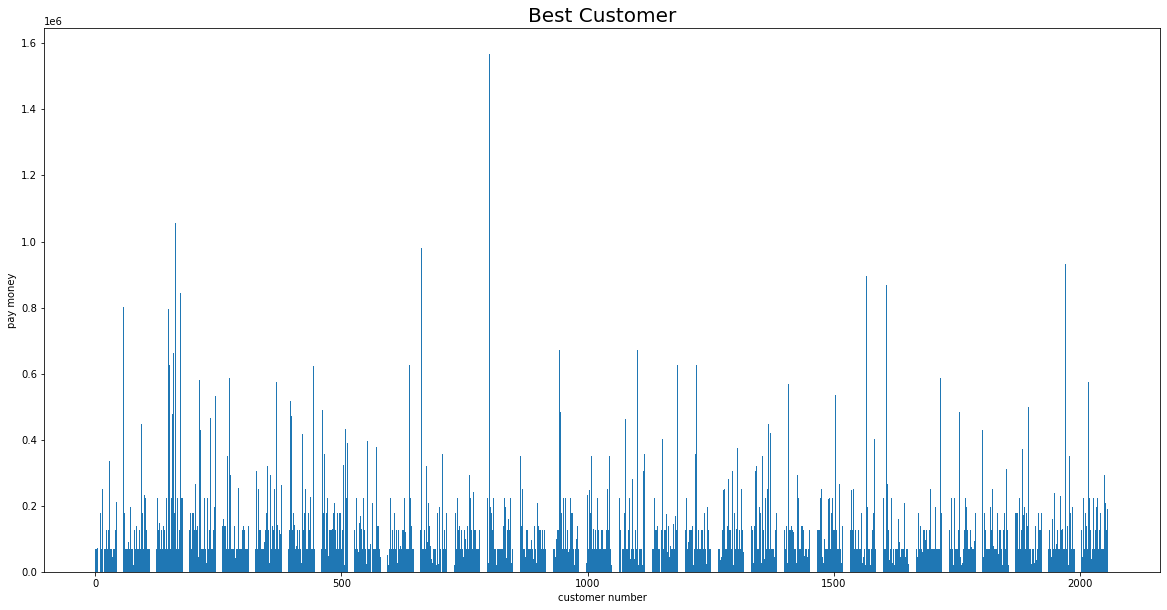

In [11]:
plt.figure(figsize=(20,10))
plt.bar(customer['수령인'], customer['누적결제금액'])
plt.title('Best Customer', fontsize=20)
plt.xlabel('customer number')
plt.ylabel('pay money')

## 3. 데이터 전처리
### 3-1. KMeans로 고객 분류

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(customer)
print(kmeans.labels_)

customer['vip'] = kmeans.labels_
customer_result = customer.groupby(['vip']).count()
print(customer_result)

[3 3 0 ... 0 3 2]
      수령인  총구매제품갯수  누적결제금액  구매시도  구매횟수  1회당평균구매금액  재주문기간(일)
vip                                                        
0     858      858     858   858   858        858       858
1      37       37      37    37    37         37        37
2     165      165     165   165   165        165       165
3    1000     1000    1000  1000  1000       1000      1000


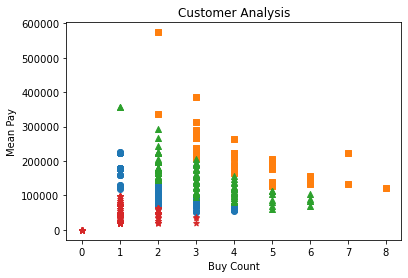

In [13]:
# cluster 값이 0, 1, 2 인 경우마다 별도의 Index로 추출
marker0_ind = customer[customer['vip']==0].index
marker1_ind = customer[customer['vip']==1].index
marker2_ind = customer[customer['vip']==2].index
marker3_ind = customer[customer['vip']==3].index
#marker4_ind = customer[customer['vip']==4].index

# cluster값 0, 1, 2에 해당하는 Index로 각 cluster 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 marker 표시
plt.scatter(x=customer.loc[marker0_ind,'구매횟수'], y=customer.loc[marker0_ind,'1회당평균구매금액'], marker='o') 
plt.scatter(x=customer.loc[marker1_ind,'구매횟수'], y=customer.loc[marker1_ind,'1회당평균구매금액'], marker='s')
plt.scatter(x=customer.loc[marker2_ind,'구매횟수'], y=customer.loc[marker2_ind,'1회당평균구매금액'], marker='^')
plt.scatter(x=customer.loc[marker3_ind,'구매횟수'], y=customer.loc[marker3_ind,'1회당평균구매금액'], marker='*')
#plt.scatter(x=customer.loc[marker4_ind,'구매횟수'], y=customer.loc[marker4_ind,'1회당평균구매금액'], marker='v')

plt.xlabel('Buy Count')
plt.ylabel('Mean Pay')
plt.title('Customer Analysis')
plt.show()

<AxesSubplot:xlabel='vip', ylabel='누적결제금액'>

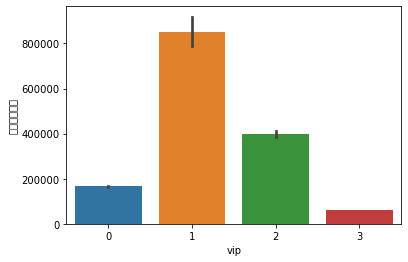

In [14]:
sns.barplot(x='vip', y='누적결제금액', data=customer)

<AxesSubplot:xlabel='구매횟수', ylabel='누적결제금액'>

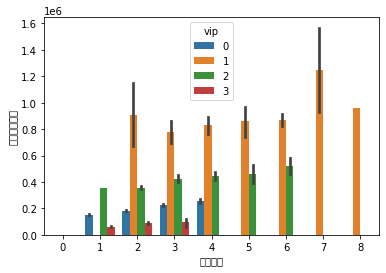

In [15]:
sns.barplot(x='구매횟수', y='누적결제금액', hue='vip', data=customer)

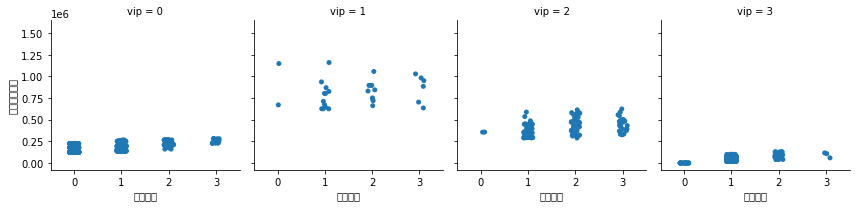

In [16]:
grid = sns.FacetGrid(data=customer, col='vip')
grid.map(sns.stripplot, "구매횟수", "누적결제금액")

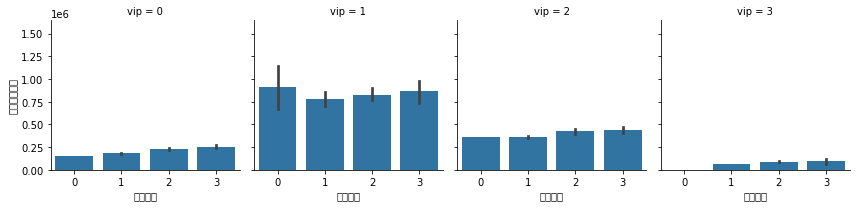

In [17]:
grid = sns.FacetGrid(data=customer, col='vip')
grid.map(sns.barplot, "구매횟수", "누적결제금액")

### 3-2. 데이터세트 전처리 (df_join)

In [18]:
# 숫자형 컬럼만 선택 사실상 모든 데이터
df_join = df.set_index('수령인').join(customer.set_index('수령인'))
df_join.drop(['총구매제품갯수', '1회당평균구매금액', '주문상품명', '주문상품명(옵션포함)', '수령인 우편번호', '수령인 주소', '결제수단',
              '발주일', '배송국가', '지난발주일', '주문번호', '품목별 주문번호'], axis=1, inplace=True)
df_join.reset_index(inplace=True)
df_join

,수령인,총 주문금액,총 결제금액,상품번호,수량,판매가,결제구분,옵션수량,총수량,거래경과일수,실결제금액,누적결제금액,구매시도,구매횟수,재주문기간(일),vip
0,0,19800.0,19800.0,103,1,19800.0,1,1.0,1.0,0.0,19800.0,19800,3,1,0,3
1,0,25700.0,25700.0,118,0,22200.0,0,1.0,0.0,0.0,0.0,19800,3,1,0,3
2,0,27500.0,27500.0,134,0,27500.0,0,1.0,0.0,0.0,0.0,19800,3,1,0,3
3,1,69900.0,69900.0,96,1,69900.0,1,1.0,1.0,0.0,69900.0,69900,1,1,0,3
4,2,125800.0,122800.0,96,1,69900.0,1,2.0,2.0,0.0,125800.0,125800,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2056,126000.0,124000.0,96,1,69900.0,1,2.0,2.0,0.0,126000.0,126000,1,1,0,0
2873,2057,126000.0,123500.0,96,1,69900.0,1,2.0,2.0,0.0,126000.0,126000,1,1,0,0
2874,2058,44500.0,42500.0,118,1,22200.0,1,1.0,1.0,0.0,44500.0,44500,1,1,0,3
2875,2059,145600.0,143600.0,103,1,19800.0,1,1.0,1.0,0.0,145600.0,291200,2,2,0,2


<AxesSubplot:xlabel='vip', ylabel='누적결제금액'>

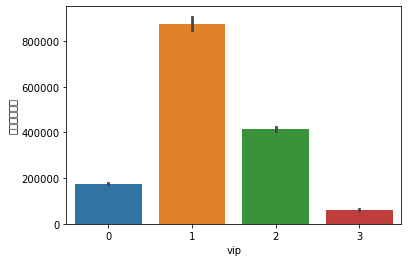

In [19]:
sns.barplot(x='vip', y='누적결제금액', data=df_join)

### 3-3. 데이터전처리 (df_final)
쇼핑몰 마켓팅에서 가장 많이 적용하는 RFM 차용  
RFM은 구매의 최근성(Recency), 구매 빈도(Frequency), 총 구매 금액 (Monetary)의 약자  
RFM을 기준으로 고객 분류 알고리즘

In [20]:
# 처음 의도대로 RFM
df_final = df.set_index('수령인').join(customer.set_index('수령인'))
df_final.reset_index(inplace=True)
df_final = df_final[['수령인', '누적결제금액', '구매시도', '구매횟수', '재주문기간(일)', 'vip']]
df_final

,수령인,누적결제금액,구매시도,구매횟수,재주문기간(일),vip
0,0,19800,3,1,0,3
1,0,19800,3,1,0,3
2,0,19800,3,1,0,3
3,1,69900,1,1,0,3
4,2,125800,1,1,0,0
...,...,...,...,...,...,...
2872,2056,126000,1,1,0,0
2873,2057,126000,1,1,0,0
2874,2058,44500,1,1,0,3
2875,2059,291200,2,2,0,2


## 4. Model
### 4-1. df_join XGBClassifier

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# X, y
X = df_join.drop(['vip'], axis=1)
y = df_join['vip']

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분리
X_train , X_test, y_train , y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# 모델
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 예측
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

[10:41:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       350
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00       148
           3       1.00      0.99      1.00       319

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



df_join 정확도 :  0.9965277777777778


Text(0.5, 1.0, 'Confusion Matrix')

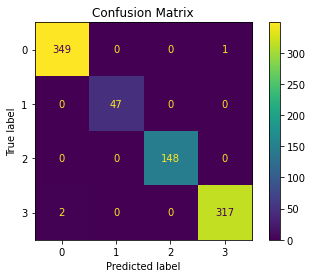

In [22]:
print("df_join 정확도 : ", xgb.score(X_test, y_test))
plot = plot_confusion_matrix(xgb,
                             X_test, y_test,
                             normalize=None)
plot.ax_.set_title('Confusion Matrix')

### 4-2. df_join PCA

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# X,y 분리
X = df_join.drop('vip', axis=1)
y = df_join['vip']

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 차원축소
pca = PCA(n_components=8)
pca_transformed = pca.fit_transform(X_scaled)

df_join['pca_x'] = pca_transformed[:,0]
df_join['pca_y'] = pca_transformed[:,1]
df_join.head(3)

,수령인,총 주문금액,총 결제금액,상품번호,수량,판매가,결제구분,옵션수량,총수량,거래경과일수,실결제금액,누적결제금액,구매시도,구매횟수,재주문기간(일),vip,pca_x,pca_y
0,0,19800.0,19800.0,103,1,19800.0,1,1.0,1.0,0.0,19800.0,19800,3,1,0,3,-2.697953,0.846110
1,0,25700.0,25700.0,118,0,22200.0,0,1.0,0.0,0.0,0.0,19800,3,1,0,3,-4.118406,1.265130
2,0,27500.0,27500.0,134,0,27500.0,0,1.0,0.0,0.0,0.0,19800,3,1,0,3,-4.190203,1.229469


In [24]:
# 컴포넌트 별 변동성 확인 7개 0.91 / 8개 0.94
print('PCA 컴포넌트 별 변동성 : ', pca.explained_variance_ratio_)

PCA 컴포넌트 별 변동성 :  [0.34490781 0.18913405 0.09816286 0.07931774 0.06859104 0.06376801
 0.05551999 0.03553262]


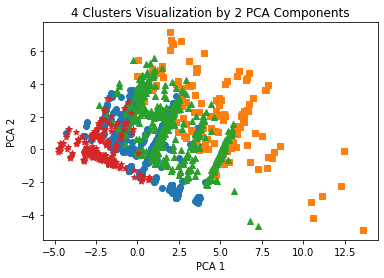

In [25]:
# cluster 값이 0, 1, 2 인 경우마다 별도의 Index로 추출
marker0_ind = df_join[df_join['vip']==0].index
marker1_ind = df_join[df_join['vip']==1].index
marker2_ind = df_join[df_join['vip']==2].index
marker3_ind = df_join[df_join['vip']==3].index

# cluster값 0, 1, 2에 해당하는 Index로 각 cluster 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 marker 표시
plt.scatter(x=df_join.loc[marker0_ind,'pca_x'], y=df_join.loc[marker0_ind,'pca_y'], marker='o') 
plt.scatter(x=df_join.loc[marker1_ind,'pca_x'], y=df_join.loc[marker1_ind,'pca_y'], marker='s')
plt.scatter(x=df_join.loc[marker2_ind,'pca_x'], y=df_join.loc[marker2_ind,'pca_y'], marker='^')
plt.scatter(x=df_join.loc[marker3_ind,'pca_x'], y=df_join.loc[marker3_ind,'pca_y'], marker='*')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('4 Clusters Visualization by 2 PCA Components')
plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 원본 데이터로 랜덤포레스트 교차검증 수행
rf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rf, X, y, scoring='accuracy', cv=3)
print('원본 CV=3인 경우 개별 fold세트별 정확도 : ', scores)
print('원본 평균 정확도 : {0:.4f}'.format(np.mean(scores)))

# pca 랜덤포레스트 교차검증
scores_pca = cross_val_score(rf, pca_transformed, y, scoring='accuracy', cv=3)
print('PCA CV=3인 경우 개별 fold세트별 정확도 : ', scores_pca)
print('PCA 평균 정확도 : {0:.4f}'.format(np.mean(scores_pca)))

원본 CV=3인 경우 개별 fold세트별 정확도 :  [0.99895725 0.98435871 0.98748697]
원본 평균 정확도 : 0.9903
PCA CV=3인 경우 개별 fold세트별 정확도 :  [0.7987487  0.88633994 0.89781022]
PCA 평균 정확도 : 0.8610


### 4-2. df_final

In [27]:
# X, y
X = df_final.drop(['vip'], axis=1)
y = df_final['vip']

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분리
X_train , X_test, y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 모델
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 예측
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

[10:41:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       350
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00       148
           3       1.00      0.99      0.99       319

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



df_final 정확도 :  0.9953703703703703


Text(0.5, 1.0, 'Confusion Matrix')

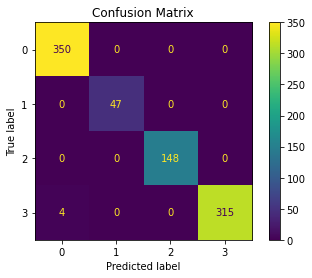

In [28]:
print("df_final 정확도 : ", xgb.score(X_test, y_test))
plot = plot_confusion_matrix(xgb,
                             X_test, y_test,
                             normalize=None)
plot.ax_.set_title('Confusion Matrix')

In [31]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

standard = StandardScaler()
xgb = XGBClassifier()

# 파이프라인
pipe = make_pipeline(standard, xgb)

# KFold 교차검증 수행
kf = KFold(n_splits=10, shuffle=True, random_state=156)
kf_result = cross_val_score(pipe,
                         X, y,
                         cv=kf,
                         scoring='accuracy')

print(kf_result.mean())

[11:04:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

## 5. 결과
### 데이터세트 1. df_join
데이터크기 2877rows, 16columns

target : vip

x 칼럼  
수령인, 총 주문금액, 총 결제금액, 상품번호, 수량, 판매가, 결제구분, 옵션수량, 총수량, 거래경과일수, 실결제금액, 누적결제금액, 구매시도, 구매횟수, 재주문기간(일)

vip분류 - k이웃 이용하여 4개로 분류 => 2, 3, 4, 5 해보니 4가 제일 잘 나눠짐

모델 - XGBClassifier  
0.99652778 과적합 의심  
랜덤포레스트 교차검증 3 평균 : 0.9903

모델 - PCA(n_conponents=8)  
랜덤포레스트 교차검증 3 평균 : 0.8561

### 데이터세트 2. df_final
데이터크기 2877rows, 6columns

target : vip

x 칼럼  
수령인, 누적결제금액, 구매시도, 구매횟수, 재주문기간(일)

vip분류 - k이웃 이용하여 4개로 분류 => 2, 3, 4, 5 해보니 4가 제일 잘 나눠짐

모델 - XGBClassifier  
0.9953703703703703 과적합 의심  
kfold 교차검증 평균 : 0.9989 과적합 의심

### 결론
고객분류를 통해 첫구매 쿠폰, 재구매 쿠폰 발급 대상 지정하여 구매유도  
우량고객 vip 설정으로 추가 혜택 제공하여 고객유지  

### 아쉬운점
vip별로 1회 평균 구매 금액 확인해서 미끼상품금액결정(제일 안사는 사람들을 위한 상품)  
베스트상품 금액결정(제일 잘 팔리는 상품 가격을 올려도 될까?에 대한 해답)  
시간이 부족해 전처리고민을 많이 못함

In [33]:
# vip별 평균 구매금액
df_join.drop(['pca_x', 'pca_y'], axis=1, inplace=True)
df_join

,수령인,총 주문금액,총 결제금액,상품번호,수량,판매가,결제구분,옵션수량,총수량,거래경과일수,실결제금액,누적결제금액,구매시도,구매횟수,재주문기간(일),vip
0,0,19800.0,19800.0,103,1,19800.0,1,1.0,1.0,0.0,19800.0,19800,3,1,0,3
1,0,25700.0,25700.0,118,0,22200.0,0,1.0,0.0,0.0,0.0,19800,3,1,0,3
2,0,27500.0,27500.0,134,0,27500.0,0,1.0,0.0,0.0,0.0,19800,3,1,0,3
3,1,69900.0,69900.0,96,1,69900.0,1,1.0,1.0,0.0,69900.0,69900,1,1,0,3
4,2,125800.0,122800.0,96,1,69900.0,1,2.0,2.0,0.0,125800.0,125800,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2056,126000.0,124000.0,96,1,69900.0,1,2.0,2.0,0.0,126000.0,126000,1,1,0,0
2873,2057,126000.0,123500.0,96,1,69900.0,1,2.0,2.0,0.0,126000.0,126000,1,1,0,0
2874,2058,44500.0,42500.0,118,1,22200.0,1,1.0,1.0,0.0,44500.0,44500,1,1,0,3
2875,2059,145600.0,143600.0,103,1,19800.0,1,1.0,1.0,0.0,145600.0,291200,2,2,0,2


In [43]:
df_mean = df_join.groupby(df_join['vip']).mean()
df_mean.reset_index(inplace=True)
df_mean

,vip,수령인,총 주문금액,총 결제금액,상품번호,수량,판매가,결제구분,옵션수량,총수량,거래경과일수,실결제금액,누적결제금액,구매시도,구매횟수,재주문기간(일)
0,0,988.924497,119805.536913,104383.828020,97.958893,1.008389,69637.835570,0.993289,1.928691,1.937919,12.113255,119244.043624,176059.479866,1.704698,1.686242,12.019295
1,1,819.448718,202176.923077,177053.467949,99.006410,1.102564,69539.102564,1.000000,2.762821,2.961538,20.217949,202176.923077,876346.794872,4.692308,4.692308,19.762821
2,2,921.637712,140273.093220,121921.476695,98.966102,1.059322,65633.474576,0.995763,2.059322,2.122881,23.718220,139746.822034,415508.898305,3.258475,3.243644,23.415254
3,3,1067.345317,61179.280984,50322.823084,100.981079,1.028382,55774.077578,0.964995,1.034059,1.055818,1.167455,58527.436140,62555.439924,1.122990,1.057711,1.153264


<AxesSubplot:xlabel='vip', ylabel='총수량'>

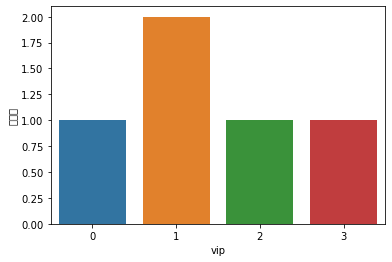

In [42]:
sns.barplot(x=df_mean['vip'], y=df['총수량'])

<AxesSubplot:xlabel='vip', ylabel='재주문기간(일)'>

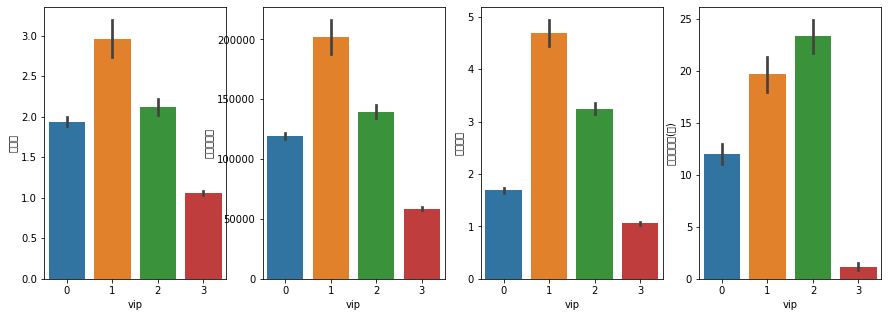

In [57]:
fig, ax = plt.subplots(ncols=4)
fig.set_size_inches(15, 5)
sns.barplot('vip', '총수량', data=df_join, ax=ax[0])
sns.barplot('vip', '실결제금액', data=df_join, ax=ax[1])
sns.barplot('vip', '구매횟수', data=df_join, ax=ax[2])
sns.barplot('vip', '재주문기간(일)', data=df_join, ax=ax[3])